<a href="https://colab.research.google.com/github/CobaMasa/RStan2PyStan/blob/20200422/chapter8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chap8-3: Non Linear Hierarchical Model

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns

import pystan

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load data
conc2 = pd.read_csv('drive/My Drive/Colab/RStanBook/chap08/input/data-conc-2.txt')
print('shape: ', conc2.shape)
conc2

shape:  (16, 7)


,PersonID,Time1,Time2,Time4,Time8,Time12,Time24
0,1,2.4,5.0,7.5,11.9,12.5,12.7
1,2,1.4,3.9,4.4,7.7,6.4,8.3
2,3,5.2,9.4,19.4,20.2,22.7,24.9
3,4,6.7,12.6,19.1,23.4,25.8,26.1
4,5,0.3,4.7,7.0,10.2,12.9,14.8
5,6,6.3,3.8,11.8,9.2,13.9,18.2
6,7,3.0,4.2,8.8,15.4,10.7,16.2
7,8,6.2,6.8,9.4,11.3,12.4,14.7
8,9,14.4,17.0,22.7,29.8,33.0,32.2
9,10,7.7,10.0,14.8,15.3,18.0,18.7


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


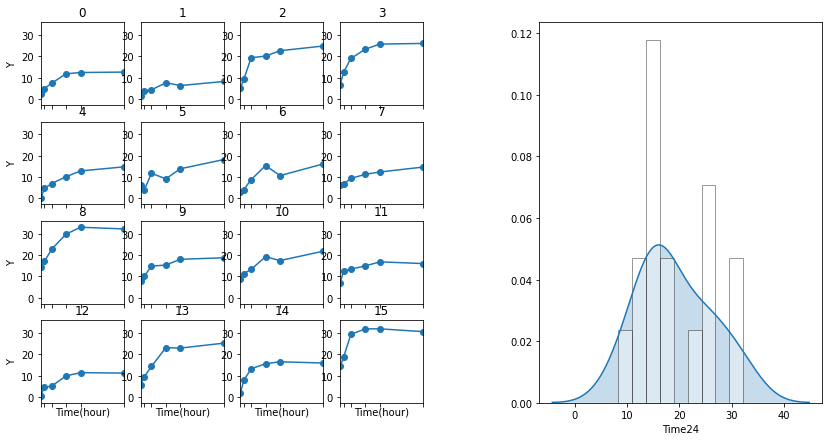

In [3]:
# See what's happening
## First of all, clean data
import warnings
warnings.filterwarnings('ignore') # Just ignore the messeges like 'Y is ambiguous!!' or something. Who cares.

Time = [1, 2, 4, 8, 12, 24]
d = pd.melt(frame=conc2, id_vars='PersonID', var_name='Time', value_name='Y')
d['Time'] = d['Time'].map({'Time{}'.format(t): t for t in Time})

## Visualization
fig = plt.figure(figsize=(14, 7))
gs_master = GridSpec(4, 8)


### 1. Effect of medicine and its duration by each patients
gs_1 = GridSpecFromSubplotSpec(nrows=4, ncols=4, subplot_spec=gs_master[:, :4])
for idx, (row, col) in enumerate(np.ndindex(4, 4)):
    ax = fig.add_subplot(gs_1[row, col])
    ax.plot('Time', 'Y', data=d.query('PersonID==@idx +1'), ls='-', marker='o')
    
    plt.setp(ax, title=idx, xlim=(d.Time.min(), d.Time.max()),  ylim=(d.Y.min()-3, d.Y.max()+3), xticks=Time, yticks=np.arange(0, 40, 10))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    if row == 3:
        plt.setp(ax, xlabel='Time(hour)')
    if col == 0:
        plt.setp(ax, ylabel='Y')

### 2. Histgram about when the effect of the medicine has reached its peaked(Remaining effects in 24h aft injctn).
gs_2 = GridSpecFromSubplotSpec(nrows=4, ncols=4, subplot_spec=gs_master[:, 5:])
ax = fig.add_subplot(gs_2[:, :])
hist_kwgs = {'facecolor': 'w', 'edgecolor': 'k'}
kde_kwgs = {'shade': True}
sns.distplot(d.query('Time==24')['Y'], bins=9, hist_kws=hist_kwgs, kde_kws=kde_kwgs, axlabel='Time24', ax=ax)

plt.show();

## Make Stan model
$$
\begin{eqnarray}
    Y[n, t]&〜&Normal(a[n]\{1-\exp(-b[n]Time[t])\}, \sigma_Y)\\
    \log(a[n])&〜&Normal(a_{global}, \sigma_a)\\
    \log(b[n])&〜&Normal(b_{global}, \sigma_b)
\end{eqnarray}
$$

In [4]:
from google.colab import files
files.upload()

Saving model8-7.stan to model8-7 (1).stan


{'model8-7.stan': b'data {\n  int N;\n  int T;\n  real Time[T];\n  real Y[N,T];\n  int T_new;\n  real Time_new[T_new];\n}\n\nparameters {\n  real a0;\n  real b0;\n  real log_a[N];\n  real log_b[N];\n  real<lower=0> s_a;\n  real<lower=0> s_b;\n  real<lower=0> s_Y;\n}\n\ntransformed parameters {\n  real a[N];\n  real b[N];\n  for (n in 1:N) {\n    a[n] = exp(log_a[n]);\n    b[n] = exp(log_b[n]);\n  }\n}\n\nmodel {\n  for (n in 1:N) {\n    log_a[n] ~ normal(a0, s_a);\n    log_b[n] ~ normal(b0, s_b);\n  }\n  for (n in 1:N)\n    for (t in 1:T)\n      Y[n,t] ~ normal(a[n]*(1 - exp(-b[n]*Time[t])), s_Y);\n}\n\ngenerated quantities {\n  real y_new[N,T_new];\n  for (n in 1:N)\n    for (t in 1:T_new)\n      y_new[n,t] = normal_rng(a[n]*(1 - exp(-b[n]*Time_new[t])), s_Y);\n}\n'}

In [0]:
T_new = 60
StanData = {
    'N': conc2.shape[0],
    'T': len(d.Time.unique()),
    'Y': conc2.loc[:, 'Time1':'Time24'],
    'Time': d.Time.unique(),
    'T_new': T_new,
    'Time_new': np.linspace(0, 24, T_new)
}

In [6]:
sm = pystan.StanModel(file='model8-7.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c679b3cbe2c58b73ccc8a662c4d1b9d NOW.


In [7]:
fit = sm.sampling(data=StanData)
fit

To run all diagnostics call pystan.check_hmc_diagnostics(fit)



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_2c679b3cbe2c58b73ccc8a662c4d1b9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
a0             2.86  1.5e-3   0.11   2.64   2.79    2.86   2.93   3.06   5189    1.0
b0            -1.18  2.0e-3   0.12  -1.43  -1.25   -1.17  -1.09  -0.95   3872    1.0
log_a[1]       2.56  1.4e-3    0.1   2.36   2.49    2.56   2.62   2.75   4974    1.0
log_a[2]       2.11  2.2e-3   0.14   1.84   2.02    2.11    2.2   2.38   4058    1.0
log_a[3]       3.17  7.3e-4   0.05   3.07   3.14    3.17   3.21   3.28   5038    1.0
log_a[4]       3.25  6.1e-4   0.04   3.17   3.22    3.25   3.28   3.34   5455    1.0
log_a[5]       2.64  1.8e-3   0.11   2.43   2.57    2.63   2.71   2.86   3810    1.0
log_a[6]       2.74  1.5e-3    0.1   2.57   2.68    2.74   2.81   2.94   3826    1.0
log_a[

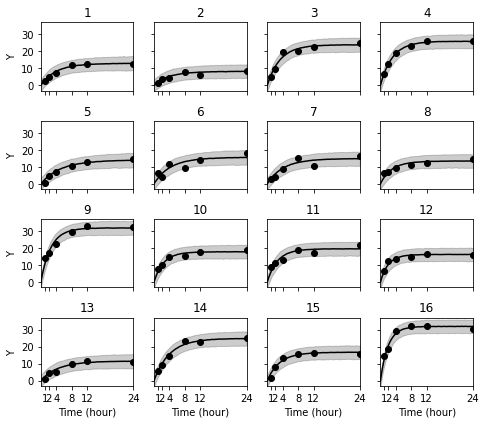

In [8]:
ms = fit.extract()
N = conc2.index.size
Time_new = np.linspace(0, 24, T_new)

probs = (2.5, 50, 97.5)
qua = np.transpose(np.percentile(ms['y_new'], (2.5, 50, 97.5), axis=0), axes=(1, 2, 0))
d_est = pd.DataFrame(qua.reshape((-1, 3)), columns=['p{}'.format(p) for p in probs])
d_est['PersonID'] = np.repeat(np.arange(N)+1, T_new)
d_est['Time'] = np.tile(Time_new, N)

Time_tbl = pd.Series(Time, index=['Time{}'.format(t) for t in Time])
d = pd.melt(conc2, id_vars='PersonID', var_name='Time', value_name='Y')
d['Time'] = Time_tbl[d['Time']].values

_, axes = plt.subplots(4, 4, figsize=figaspect(7/8)*1.5)
for (row, col), ax in np.ndenumerate(axes):
    person = row * 4+ col + 1
    ax.fill_between('Time', 'p2.5', 'p97.5', data=d_est.query('PersonID==@person'), color='k', alpha=1/5)
    ax.plot('Time', 'p50', data=d_est.query('PersonID==@person'), color='k')
    ax.scatter('Time', 'Y', data=d.query('PersonID==@person'), color='k')
    if row < 3:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.setp(ax, xlabel='Time (hour)')
    if col > 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        plt.setp(ax, ylabel='Y')
    plt.setp(ax, title=person, xticks=Time, xlim=(0, 24), yticks=np.arange(0, 40, 10), ylim=(-3, 37))
plt.tight_layout()
plt.show();